## Question 1
The goal is to analyze the FAA Wildlife Strike Database to identify patterns and trends in wildlife
strikes to civil aircraft. We must clean and reduce the dataset to only include relevant features for
the analysis. We must examine factors such as aircraft type, wildlife involved, location, and time.
After extracting factors like these we perform statistical tests, test hypotheses, and create visualizations
to help reduce the occurance and impact of wildlife strikes on civil aircraft in the future.

## Question 2

Load the data using pandas and inspect it.

Perform the initial inspection of the data, its shape, types, etc.

Evaluate the dataset and perform at least three type of data preparation and justify the approach that is taken to prepare the data for analysis. Data prep can include, but is not limited to: handling missing values, data types, duplicates, etc. You will need to ensure that your data preparation addressed issues in at least 7 fields in the data.

Prepare meaningful* summary statistics for 3 continuous variables and 3 categorical variables.
Note: meaningful summary statistics explains the statistical summary of relevant fields in a coherent manner.

In [22]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import skew

data = pd.read_csv("Bird_Strikes_1990_2023.csv")
data

C:\Users\sshei\AppData\Local\Temp\ipykernel_17540\681545909.py:12: DtypeWarning: Columns (18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Bird_Strikes_1990_2023.csv")


,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,LATITUDE,LONGITUDE,...,SIZE,NR_INJURIES,NR_FATALITIES,COMMENTS,REPORTED_NAME,REPORTED_TITLE,SOURCE,PERSON,LUPDATE,TRANSFER
0,608242,6/22/1996,6,1996,NaN,NaN,KSMF,SACRAMENTO INTL,38.69542,-121.59077,...,Medium,NaN,NaN,/Legacy Record=100001/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
1,608243,6/26/1996,6,1996,NaN,NaN,KDEN,DENVER INTL AIRPORT,39.85841,-104.66700,...,Medium,NaN,NaN,/Legacy Record=100002/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
2,608244,7/1/1996,7,1996,NaN,NaN,KOMA,EPPLEY AIRFIELD,41.30252,-95.89417,...,Medium,NaN,NaN,/Legacy Record=100003/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
3,608245,7/1/1996,7,1996,NaN,NaN,KIAD,WASHINGTON DULLES INTL ARPT,38.94453,-77.45581,...,Medium,NaN,NaN,/Legacy Record=100004/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
4,608246,7/1/1996,7,1996,NaN,NaN,KLGA,LA GUARDIA ARPT,40.77724,-73.87261,...,Medium,NaN,NaN,/Legacy Record=100005/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288805,1472253,8/28/2023,8,2023,21:50,NaN,ZZZZ,UNKNOWN,NaN,NaN,...,Small,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False
288806,1472256,8/28/2023,8,2023,20:40,NaN,ZZZZ,UNKNOWN,NaN,NaN,...,Small,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False
288807,1472257,8/28/2023,8,2023,07:14,Dusk,KDTW,DETROIT METRO WAYNE COUNTY ARPT,42.21206,-83.34884,...,Small,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False
288808,1472258,8/28/2023,8,2023,09:00,Day,KPIH,POCATELLO REGIONAL ARPT,42.91131,-112.59586,...,Medium,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False


In [2]:
data.dtypes

INDEX_NR           int64
INCIDENT_DATE     object
INCIDENT_MONTH     int64
INCIDENT_YEAR      int64
TIME              object
                   ...  
REPORTED_TITLE    object
SOURCE            object
PERSON            object
LUPDATE           object
TRANSFER            bool
Length: 100, dtype: object

In [3]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288810 entries, 0 to 288809
Data columns (total 100 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   INDEX_NR               288810 non-null  int64  
 1   INCIDENT_DATE          288810 non-null  object 
 2   INCIDENT_MONTH         288810 non-null  int64  
 3   INCIDENT_YEAR          288810 non-null  int64  
 4   TIME                   163633 non-null  object 
 5   TIME_OF_DAY            166394 non-null  object 
 6   AIRPORT_ID             288804 non-null  object 
 7   AIRPORT                288810 non-null  object 
 8   LATITUDE               253309 non-null  float64
 9   LONGITUDE              253308 non-null  float64
 10  RUNWAY                 218852 non-null  object 
 11  STATE                  253309 non-null  object 
 12  FAAREGION              253309 non-null  object 
 13  LOCATION               33939 non-null   object 
 14  ENROUTE_STATE          5037 non-nul

In [4]:
print("\nMissing values per column (top 10):")
print(data.isnull().sum().sort_values(ascending=False).head(10))


Missing values per column (top 10):
NR_FATALITIES            288786
NR_INJURIES              288534
BIRD_BAND_NUMBER         288420
EFFECT_OTHER             286589
ENG_4_POS                285520
COST_OTHER_INFL_ADJ      284050
COST_OTHER               284050
ENROUTE_STATE            283773
COST_REPAIRS_INFL_ADJ    283770
COST_REPAIRS             283770
dtype: int64


In [5]:
# fix categories 
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288810 entries, 0 to 288809
Data columns (total 100 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   INDEX_NR               288810 non-null  int64  
 1   INCIDENT_DATE          288810 non-null  object 
 2   INCIDENT_MONTH         288810 non-null  int64  
 3   INCIDENT_YEAR          288810 non-null  int64  
 4   TIME                   163633 non-null  object 
 5   TIME_OF_DAY            166394 non-null  object 
 6   AIRPORT_ID             288804 non-null  object 
 7   AIRPORT                288810 non-null  object 
 8   LATITUDE               253309 non-null  float64
 9   LONGITUDE              253308 non-null  float64
 10  RUNWAY                 218852 non-null  object 
 11  STATE                  253309 non-null  object 
 12  FAAREGION              253309 non-null  object 
 13  LOCATION               33939 non-null   object 
 14  ENROUTE_STATE          5037 non-nul

In [6]:
# Identify object-type columns (potential categorical variables)
cat_cols = data.select_dtypes(include='object').columns
print("Possible categorical fields:", len(cat_cols))
print(cat_cols.tolist())


Possible categorical fields: 43
['INCIDENT_DATE', 'TIME', 'TIME_OF_DAY', 'AIRPORT_ID', 'AIRPORT', 'RUNWAY', 'STATE', 'FAAREGION', 'LOCATION', 'ENROUTE_STATE', 'OPID', 'OPERATOR', 'REG', 'FLT', 'AIRCRAFT', 'AMA', 'AMO', 'AC_CLASS', 'TYPE_ENG', 'PHASE_OF_FLIGHT', 'SKY', 'PRECIPITATION', 'COST_REPAIRS', 'COST_OTHER', 'COST_REPAIRS_INFL_ADJ', 'COST_OTHER_INFL_ADJ', 'DAMAGE_LEVEL', 'OTHER_SPECIFY', 'EFFECT', 'EFFECT_OTHER', 'SPECIES_ID', 'SPECIES', 'REMARKS', 'WARNED', 'NUM_SEEN', 'NUM_STRUCK', 'SIZE', 'COMMENTS', 'REPORTED_NAME', 'REPORTED_TITLE', 'SOURCE', 'PERSON', 'LUPDATE']


In [7]:
data = data.copy()
# standardize
for col in cat_cols:
    data[col] = data[col].astype(str).str.strip()
    data[col] = data[col].replace(['nan', 'NaN', 'None', 'UNKNOWN', 'Unknown'], np.nan)

# normalize text capitalization for key fields
data['STATE'] = data['STATE'].str.upper()
data['AIRPORT'] = data['AIRPORT'].str.title()
data['SPECIES'] = data['SPECIES'].str.title()
data['OPERATOR'] = data['OPERATOR'].str.title()
data['PHASE_OF_FLIGHT'] = data['PHASE_OF_FLIGHT'].str.title()
data['TIME_OF_DAY'] = data['TIME_OF_DAY'].str.title()
data['SIZE'] = data['SIZE'].str.title()
data['WARNED'] = data['WARNED'].str.capitalize()

for col in ['STATE', 'AIRPORT', 'SPECIES', 'PHASE_OF_FLIGHT', 'TIME_OF_DAY', 'SIZE']:
    data[col] = data[col].fillna('Unknown')

# convert them to category dtype 
for col in cat_cols:
    data[col] = data[col].astype('category')

# take care of dates and times 
data['TIME'] = pd.to_datetime(data['TIME'], format='%H:%M', errors='coerce').dt.time

data['INCIDENT_DATE'] = pd.to_datetime(data['INCIDENT_DATE'], errors='coerce')

data

,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,LATITUDE,LONGITUDE,...,SIZE,NR_INJURIES,NR_FATALITIES,COMMENTS,REPORTED_NAME,REPORTED_TITLE,SOURCE,PERSON,LUPDATE,TRANSFER
0,608242,1996-06-22,6,1996,NaT,Unknown,KSMF,Sacramento Intl,38.69542,-121.59077,...,Medium,NaN,NaN,/Legacy Record=100001/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
1,608243,1996-06-26,6,1996,NaT,Unknown,KDEN,Denver Intl Airport,39.85841,-104.66700,...,Medium,NaN,NaN,/Legacy Record=100002/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
2,608244,1996-07-01,7,1996,NaT,Unknown,KOMA,Eppley Airfield,41.30252,-95.89417,...,Medium,NaN,NaN,/Legacy Record=100003/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
3,608245,1996-07-01,7,1996,NaT,Unknown,KIAD,Washington Dulles Intl Arpt,38.94453,-77.45581,...,Medium,NaN,NaN,/Legacy Record=100004/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
4,608246,1996-07-01,7,1996,NaT,Unknown,KLGA,La Guardia Arpt,40.77724,-73.87261,...,Medium,NaN,NaN,/Legacy Record=100005/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288805,1472253,2023-08-28,8,2023,21:50:00,Unknown,ZZZZ,Unknown,NaN,NaN,...,Small,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False
288806,1472256,2023-08-28,8,2023,20:40:00,Unknown,ZZZZ,Unknown,NaN,NaN,...,Small,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False
288807,1472257,2023-08-28,8,2023,07:14:00,Dusk,KDTW,Detroit Metro Wayne County Arpt,42.21206,-83.34884,...,Small,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False
288808,1472258,2023-08-28,8,2023,09:00:00,Day,KPIH,Pocatello Regional Arpt,42.91131,-112.59586,...,Medium,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False


In [8]:
# check changes 
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288810 entries, 0 to 288809
Data columns (total 100 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   INDEX_NR               288810 non-null  int64         
 1   INCIDENT_DATE          288810 non-null  datetime64[ns]
 2   INCIDENT_MONTH         288810 non-null  int64         
 3   INCIDENT_YEAR          288810 non-null  int64         
 4   TIME                   163162 non-null  object        
 5   TIME_OF_DAY            288810 non-null  category      
 6   AIRPORT_ID             288804 non-null  category      
 7   AIRPORT                288810 non-null  category      
 8   LATITUDE               253309 non-null  float64       
 9   LONGITUDE              253308 non-null  float64       
 10  RUNWAY                 218852 non-null  category      
 11  STATE                  288810 non-null  category      
 12  FAAREGION              253309 non-null  cat

In [9]:
data

,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,LATITUDE,LONGITUDE,...,SIZE,NR_INJURIES,NR_FATALITIES,COMMENTS,REPORTED_NAME,REPORTED_TITLE,SOURCE,PERSON,LUPDATE,TRANSFER
0,608242,1996-06-22,6,1996,NaT,Unknown,KSMF,Sacramento Intl,38.69542,-121.59077,...,Medium,NaN,NaN,/Legacy Record=100001/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
1,608243,1996-06-26,6,1996,NaT,Unknown,KDEN,Denver Intl Airport,39.85841,-104.66700,...,Medium,NaN,NaN,/Legacy Record=100002/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
2,608244,1996-07-01,7,1996,NaT,Unknown,KOMA,Eppley Airfield,41.30252,-95.89417,...,Medium,NaN,NaN,/Legacy Record=100003/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
3,608245,1996-07-01,7,1996,NaT,Unknown,KIAD,Washington Dulles Intl Arpt,38.94453,-77.45581,...,Medium,NaN,NaN,/Legacy Record=100004/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
4,608246,1996-07-01,7,1996,NaT,Unknown,KLGA,La Guardia Arpt,40.77724,-73.87261,...,Medium,NaN,NaN,/Legacy Record=100005/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288805,1472253,2023-08-28,8,2023,21:50:00,Unknown,ZZZZ,Unknown,NaN,NaN,...,Small,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False
288806,1472256,2023-08-28,8,2023,20:40:00,Unknown,ZZZZ,Unknown,NaN,NaN,...,Small,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False
288807,1472257,2023-08-28,8,2023,07:14:00,Dusk,KDTW,Detroit Metro Wayne County Arpt,42.21206,-83.34884,...,Small,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False
288808,1472258,2023-08-28,8,2023,09:00:00,Day,KPIH,Pocatello Regional Arpt,42.91131,-112.59586,...,Medium,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False


In [10]:
# handling null values 
# if a column is missing more than 50% of the data, then remove it 
threshold = len(data) * 0.5
data = data.dropna(thresh=threshold, axis=1)
print("Remaining columns:", data.shape[1])

Remaining columns: 79


In [11]:
data

,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,LATITUDE,LONGITUDE,...,REMAINS_SENT,NUM_STRUCK,SIZE,COMMENTS,REPORTED_NAME,REPORTED_TITLE,SOURCE,PERSON,LUPDATE,TRANSFER
0,608242,1996-06-22,6,1996,NaT,Unknown,KSMF,Sacramento Intl,38.69542,-121.59077,...,False,1,Medium,/Legacy Record=100001/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
1,608243,1996-06-26,6,1996,NaT,Unknown,KDEN,Denver Intl Airport,39.85841,-104.66700,...,False,1,Medium,/Legacy Record=100002/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
2,608244,1996-07-01,7,1996,NaT,Unknown,KOMA,Eppley Airfield,41.30252,-95.89417,...,False,1,Medium,/Legacy Record=100003/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
3,608245,1996-07-01,7,1996,NaT,Unknown,KIAD,Washington Dulles Intl Arpt,38.94453,-77.45581,...,False,1,Medium,/Legacy Record=100004/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
4,608246,1996-07-01,7,1996,NaT,Unknown,KLGA,La Guardia Arpt,40.77724,-73.87261,...,False,1,Medium,/Legacy Record=100005/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288805,1472253,2023-08-28,8,2023,21:50:00,Unknown,ZZZZ,Unknown,NaN,NaN,...,True,1,Small,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False
288806,1472256,2023-08-28,8,2023,20:40:00,Unknown,ZZZZ,Unknown,NaN,NaN,...,True,1,Small,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False
288807,1472257,2023-08-28,8,2023,07:14:00,Dusk,KDTW,Detroit Metro Wayne County Arpt,42.21206,-83.34884,...,True,1,Small,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False
288808,1472258,2023-08-28,8,2023,09:00:00,Day,KPIH,Pocatello Regional Arpt,42.91131,-112.59586,...,False,2-10,Medium,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False


In [12]:
# check for duplicates 
data.duplicated().sum()

np.int64(0)

In [13]:
data['TIME_OF_DAY'].unique()

['Unknown', 'Day', 'Dawn', 'Night', 'Dusk']
Categories (5, object): ['Dawn', 'Day', 'Dusk', 'Night', 'Unknown']

In [14]:
# the data has unkonws for time of day even though the the time is known. 
# Here I define times of the day to the unique categoires of the time of day (dawn,day,dusk,etc.) 
# to add values in the data that we can directly infer all while maintaining integrity
data = data.copy()


def infer_time_of_day(t):
    if pd.isna(t):
        return np.nan
    h = t.hour
    if 5 <= h < 7:
        return 'Dawn'
    elif 7 <= h < 18:
        return 'Day'
    elif 18 <= h < 20:
        return 'Dusk'
    else:
        return 'Night'


# Create a new inferred column from TIME
data['TIME_OF_DAY_INFERRED'] = data['TIME'].apply(infer_time_of_day)

# Replace 'Unknown' only where TIME_OF_DAY is missing or 'Unknown'
mask = (data['TIME_OF_DAY'] == 'Unknown') & data['TIME_OF_DAY_INFERRED'].notna()
data.loc[mask, 'TIME_OF_DAY'] = data.loc[mask, 'TIME_OF_DAY_INFERRED']

# Drop helper column
data.drop(columns='TIME_OF_DAY_INFERRED', inplace=True)


In [15]:
data

,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,LATITUDE,LONGITUDE,...,REMAINS_SENT,NUM_STRUCK,SIZE,COMMENTS,REPORTED_NAME,REPORTED_TITLE,SOURCE,PERSON,LUPDATE,TRANSFER
0,608242,1996-06-22,6,1996,NaT,Unknown,KSMF,Sacramento Intl,38.69542,-121.59077,...,False,1,Medium,/Legacy Record=100001/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
1,608243,1996-06-26,6,1996,NaT,Unknown,KDEN,Denver Intl Airport,39.85841,-104.66700,...,False,1,Medium,/Legacy Record=100002/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
2,608244,1996-07-01,7,1996,NaT,Unknown,KOMA,Eppley Airfield,41.30252,-95.89417,...,False,1,Medium,/Legacy Record=100003/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
3,608245,1996-07-01,7,1996,NaT,Unknown,KIAD,Washington Dulles Intl Arpt,38.94453,-77.45581,...,False,1,Medium,/Legacy Record=100004/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
4,608246,1996-07-01,7,1996,NaT,Unknown,KLGA,La Guardia Arpt,40.77724,-73.87261,...,False,1,Medium,/Legacy Record=100005/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288805,1472253,2023-08-28,8,2023,21:50:00,Night,ZZZZ,Unknown,NaN,NaN,...,True,1,Small,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False
288806,1472256,2023-08-28,8,2023,20:40:00,Night,ZZZZ,Unknown,NaN,NaN,...,True,1,Small,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False
288807,1472257,2023-08-28,8,2023,07:14:00,Dusk,KDTW,Detroit Metro Wayne County Arpt,42.21206,-83.34884,...,True,1,Small,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False
288808,1472258,2023-08-28,8,2023,09:00:00,Day,KPIH,Pocatello Regional Arpt,42.91131,-112.59586,...,False,2-10,Medium,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False


In [18]:
data.describe()

,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,LATITUDE,LONGITUDE,EMA,EMO,AC_MASS,NUM_ENGS,ENG_1_POS,ENG_2_POS,HEIGHT,DISTANCE
count,2.888100e+05,288810,288810.000000,288810.000000,2.533090e+05,253308.000000,192151.000000,186756.000000,206490.000000,206259.000000,205481.000000,191612.000000,148807.000000,188234.000000
mean,8.736693e+05,2012-04-01 21:14:57.251480064,7.175974,2011.697798,2.012754e+02,-90.880247,19.755812,8.522377,3.538312,2.013929,2.814956,2.667536,865.960358,0.814466
min,6.082420e+05,1990-01-02 00:00:00,1.000000,1990.000000,-3.767333e+01,-177.381000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,6.893202e+05,2006-07-20 00:00:00,5.000000,2006.000000,3.298764e+01,-98.469780,10.000000,1.000000,3.000000,2.000000,1.000000,1.000000,0.000000,0.000000
50%,7.646935e+05,2014-03-17 00:00:00,7.000000,2014.000000,3.880581e+01,-87.904460,22.000000,4.000000,4.000000,2.000000,1.000000,1.000000,50.000000,0.000000
75%,1.064714e+06,2019-03-16 00:00:00,9.000000,2019.000000,4.085010e+01,-80.417940,31.000000,10.000000,4.000000,2.000000,5.000000,5.000000,900.000000,0.000000
max,1.472259e+06,2023-11-14 00:00:00,12.000000,2023.000000,4.115443e+07,164140.000000,92.000000,2301.000000,5.000000,4.000000,7.000000,7.000000,31300.000000,99.000000
std,2.526448e+05,NaN,2.765082,8.432311,8.177522e+04,327.243918,10.724278,12.866405,0.867312,0.420133,2.113806,1.981032,1843.098801,3.547950


In [17]:
data.columns

Index(['INDEX_NR', 'INCIDENT_DATE', 'INCIDENT_MONTH', 'INCIDENT_YEAR', 'TIME',
       'TIME_OF_DAY', 'AIRPORT_ID', 'AIRPORT', 'LATITUDE', 'LONGITUDE',
       'RUNWAY', 'STATE', 'FAAREGION', 'OPID', 'OPERATOR', 'REG', 'AIRCRAFT',
       'AMA', 'AMO', 'EMA', 'EMO', 'AC_CLASS', 'AC_MASS', 'TYPE_ENG',
       'NUM_ENGS', 'ENG_1_POS', 'ENG_2_POS', 'PHASE_OF_FLIGHT', 'HEIGHT',
       'DISTANCE', 'INGESTED_OTHER', 'INDICATED_DAMAGE', 'DAMAGE_LEVEL',
       'STR_RAD', 'DAM_RAD', 'STR_WINDSHLD', 'DAM_WINDSHLD', 'STR_NOSE',
       'DAM_NOSE', 'STR_ENG1', 'DAM_ENG1', 'ING_ENG1', 'STR_ENG2', 'DAM_ENG2',
       'ING_ENG2', 'STR_ENG3', 'DAM_ENG3', 'ING_ENG3', 'STR_ENG4', 'DAM_ENG4',
       'ING_ENG4', 'STR_PROP', 'DAM_PROP', 'STR_WING_ROT', 'DAM_WING_ROT',
       'STR_FUSE', 'DAM_FUSE', 'STR_LG', 'DAM_LG', 'STR_TAIL', 'DAM_TAIL',
       'STR_LGHTS', 'DAM_LGHTS', 'STR_OTHER', 'DAM_OTHER', 'SPECIES_ID',
       'SPECIES', 'REMARKS', 'REMAINS_COLLECTED', 'REMAINS_SENT', 'NUM_STRUCK',
       'SIZE', 'COMM

In [16]:
data.isna().sum()

INDEX_NR               0
INCIDENT_DATE          0
INCIDENT_MONTH         0
INCIDENT_YEAR          0
TIME              125648
                   ...  
REPORTED_TITLE         0
SOURCE                 0
PERSON             21134
LUPDATE                0
TRANSFER               0
Length: 79, dtype: int64

In [26]:
cat_vars = ['TIME_OF_DAY', 'STATE', 'PHASE_OF_FLIGHT']
for var in cat_vars:
    summary_cont = data[cat_vars].describe().round(2)
print(summary_cont)

       TIME_OF_DAY   STATE PHASE_OF_FLIGHT
count       166394  253309          177843
unique           4      67              11
top            Day      TX        Approach
freq        102548   24794           75224


In [ ]:
cont_vars = ['AC_MASS', 'HEIGHT', 'DISTANCE']
summary_cont = data[cont_vars].describe().round(2)
print(summary_cont)

Question 3 — Perform Exploratory Data Analysis (40 pts)

Perform an in-depth analysis by creating visualizations to understand the distribution and relationships within the data, while ensuring that your analysis and explanation of the results tell a story. It's important to select appropriate visualizations based on the type of data. Explain all results.

Analyze the proportion of incidents that occur each year.
Evaluate the distribution of bird strikes in each state and display the top 20 states.
What is the most common bird species that are involved in bird strikes.
Perform a comparative analysis of the annual aircraft damage for each phase of flight. Evaluate the results over the last 10 years to determine what patterns exist. Note: this requires a year over year analysis.
Analyze the frequency of bird strike incidents that occur on a monthly basis over the last 10 years. Analyze the results to determine when these incidents are more prevalent.  This question requires you to drill deeper into the analysis to determine if the distribution has changed over the last 10 years. Note: this requires a year over year analysis.
Perform ONE (1) additional analysis on the distribution. Ensure that you either : 1) perform a comparative analysis by evaluating 3 or more groups within the data or 2) perform a temporal analysis of the patterns over 10 or more years (this requires a year over year analysis of the patterns). Do not repeat any of the previous analysis.

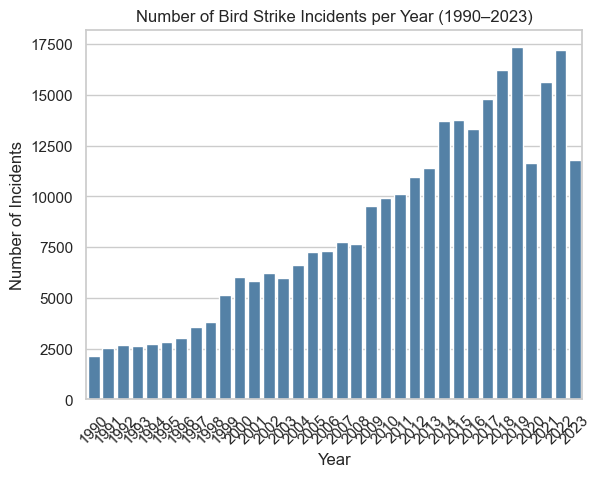

In [27]:
yearly_counts = data['INCIDENT_YEAR'].value_counts().sort_index()

sns.barplot(x=yearly_counts.index, y=yearly_counts.values, color="steelblue")
plt.title("Number of Bird Strike Incidents per Year (1990–2023)")
plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=45)
plt.show()

The chart shows a steady rise in reported bird strikes from 1990 to 2023. Incidents increased from around 2,000 per year in the early 1990s to nearly 18,000 by 2023. This growth mainly reflects more air traffic and better reporting, not necessarily more collisions. A sharp dip around 2020–2021 aligns with the COVID-19 air travel decline.Overall, the trend shows increased monitoring and awareness of bird-aircraft interactions over time.


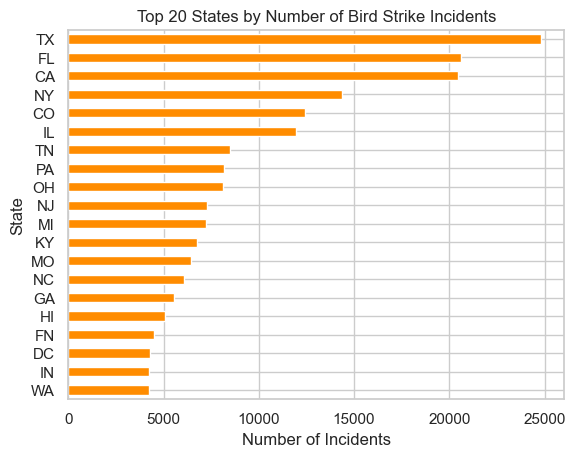

In [28]:
top_states = (data['STATE']
              .value_counts()
              .head(20)
              .sort_values(ascending=True))

top_states.plot(kind="barh", color="darkorange")
plt.title("Top 20 States by Number of Bird Strike Incidents")
plt.xlabel("Number of Incidents")
plt.ylabel("State")
plt.show()


This bar chart shows that bird strikes are concentrated in high-traffic or coastal states, with Texas, Florida, and California reporting the most incidents. New York, Colorado, and Illinois also rank high, likely due to large hub airports. The large “Unknown” category suggests many records lacked state information, possibly from flights occurring en route or over state borders. Overall, the pattern reflects both air-traffic density and migratory routes, with southern and coastal regions facing greater exposure to bird activity.

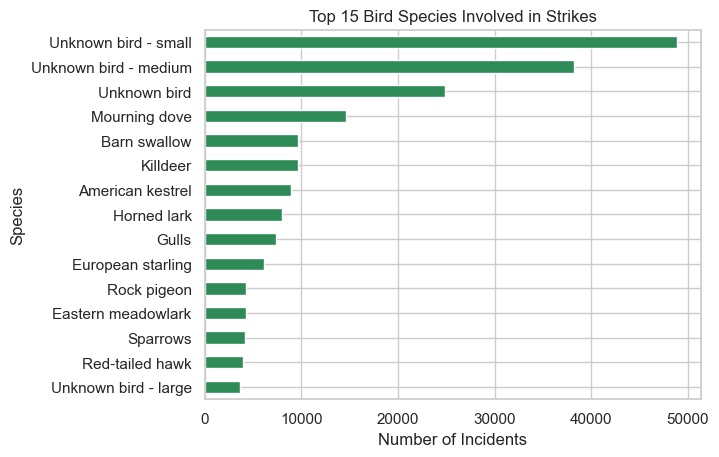

In [29]:
top_species = (data['SPECIES']
               .value_counts()
               .head(15)
               .sort_values(ascending=True))

top_species.plot(kind="barh", color="seagreen")
plt.title("Top 15 Bird Species Involved in Strikes")
plt.xlabel("Number of Incidents")
plt.ylabel("Species")
plt.show()


This chart shows that most strikes involve unidentified or small birds, with “Unknown Bird – Small” and “Unknown Bird – Medium” dominating the reports.
Among known species, Mourning Doves, Barn Swallows, and Killdeer appear most often, all of which are common near open fields and airports. The large share of “unknown” species reflects how difficult it is to identify birds after impact, but overall, smaller species are the most frequent contributors to strikes, while larger birds (though rarer) likely cause more damage.

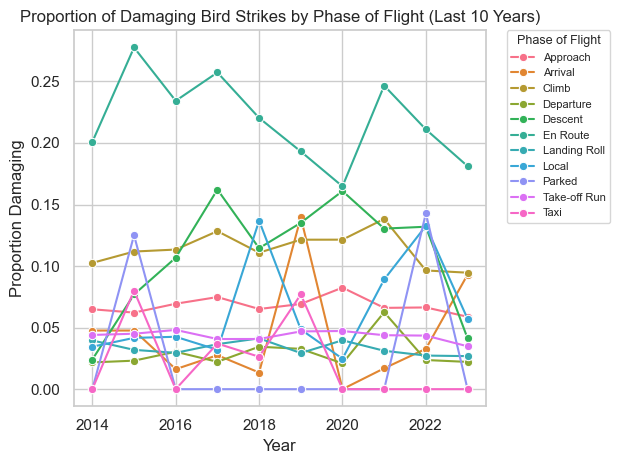

In [30]:
recent = data[data['INCIDENT_YEAR'] >= data['INCIDENT_YEAR'].max() - 9]

damage_phase = (recent.groupby(['INCIDENT_YEAR', 'PHASE_OF_FLIGHT'])
                ['INDICATED_DAMAGE']
                .mean()
                .reset_index())

sns.lineplot(data=damage_phase,
             x='INCIDENT_YEAR',
             y='INDICATED_DAMAGE',
             hue='PHASE_OF_FLIGHT',
             marker='o')

plt.title("Proportion of Damaging Bird Strikes by Phase of Flight (Last 10 Years)")
plt.xlabel("Year")
plt.ylabel("Proportion Damaging")

plt.legend(title="Phase of Flight",
           # moving legend outside the plot
           bbox_to_anchor=(1.05, 1),
           loc='upper left',
           borderaxespad=0,
           fontsize=8,
           title_fontsize=9)

plt.tight_layout()
plt.show()

Most damaging bird strikes occur during en route and approach phases, when aircraft are at altitude or descending. These phases show the highest year-to-year variation, while other phases remain relatively low and stable. It highlights that bird strikes at higher altitudes can be more severe, despite being less frequent overall.

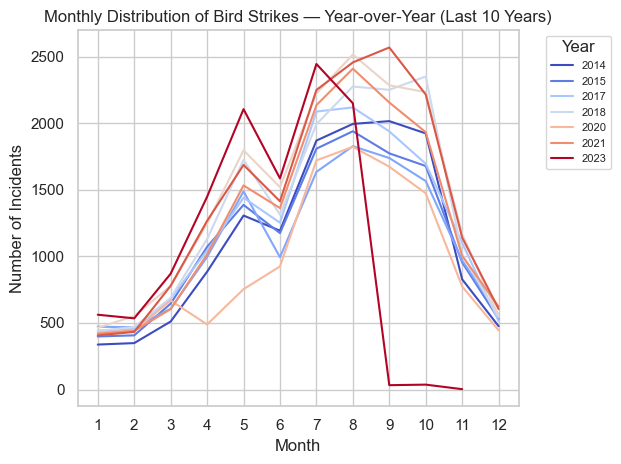

In [32]:
monthly_recent = (recent.groupby(['INCIDENT_YEAR', 'INCIDENT_MONTH'])
                  .size()
                  .reset_index(name='COUNT'))

sns.lineplot(data=monthly_recent,
             x='INCIDENT_MONTH',
             y='COUNT',
             hue='INCIDENT_YEAR',
             palette='coolwarm')
plt.title("Monthly Distribution of Bird Strikes — Year-over-Year (Last 10 Years)")
plt.xlabel("Month")
plt.ylabel("Number of Incidents")
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.xticks(range(1, 13))
plt.show()


Most damaging bird strikes occur during en route and approach phases, when aircraft are at altitude or descending. These phases show the highest year-to-year variation, while other phases remain relatively low and stable. It highlights that bird strikes at higher altitudes can be more severe, despite being less frequent overall.

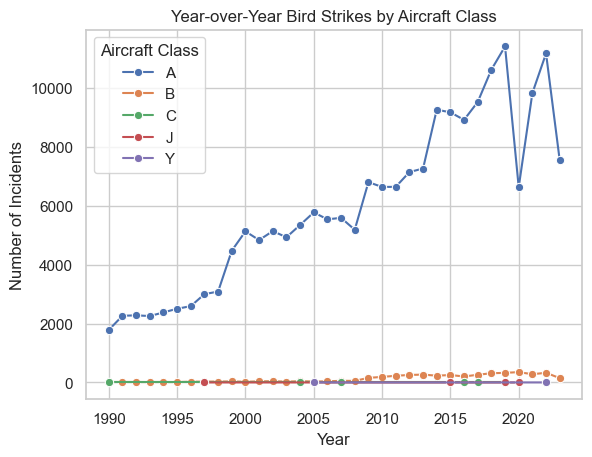

In [33]:
type_year = (data.groupby(['INCIDENT_YEAR', 'AC_CLASS'])
             .size()
             .reset_index(name='COUNT'))

sns.lineplot(data=type_year, x='INCIDENT_YEAR', y='COUNT', hue='AC_CLASS', marker='o')
plt.title("Year-over-Year Bird Strikes by Aircraft Class")
plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.legend(title="Aircraft Class")
plt.show()


This plot shows that aircraft class A experiences the vast majority of bird strikes, with incidents rising sharply since the late 1990s.
Smaller or specialized aircraft classes (B, C, J, Y) show minimal activity in comparison. The increase for class A aligns with growth in commercial jet traffic and improved reporting systems, while the other classes remain relatively constant over time. Overall, this trend highlights how larger commercial fleets account for most recorded bird strikes due to higher flight volume and exposure.

Question 4 — Hypothesis Testing (30 points)

Perform pairwise analysis of select features and evaluate the significance of the pattern or trend. A suitable value for alpha is 5%. Explain all results.

Create a scatterplot that shows the relationship between aircraft height and speed. Evaluate the correlation, the strength and the significance of the results.
Visualize the distribution of the aircraft speed during: 1) the approach phase of flight and 2) the landing roll phase of flight. Perform a 2 sample t-test and evaluate if there is a statistical difference between the speed during these two flight phases. Tip: if the data is skewed, you will need to address this prior to the statistical analysis.
Create a visualization of the aircraft damage grouped by phase of flight.
Evaluate if the results are statistically significant. Ensure that you use the appropriate test.
Perform ONE (1) additional statistical test.
Explain what you are testing and the reason this information is useful.
Visualize the data, state the hypothesis and explain if it is statistically significant.


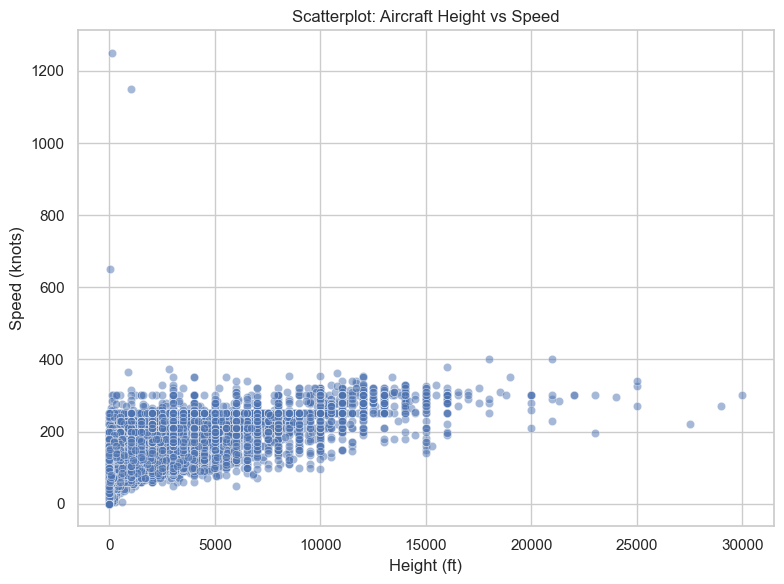

Pearson r = 0.6960, p = 0
Interpretation: Strong correlation.
Result: Statistically significant relationship (p < 0.05).
Counts — Approach: 46400, Landing Roll: 11950
Skewness — Approach: 1.449
Skewness — Landing Roll: -0.615


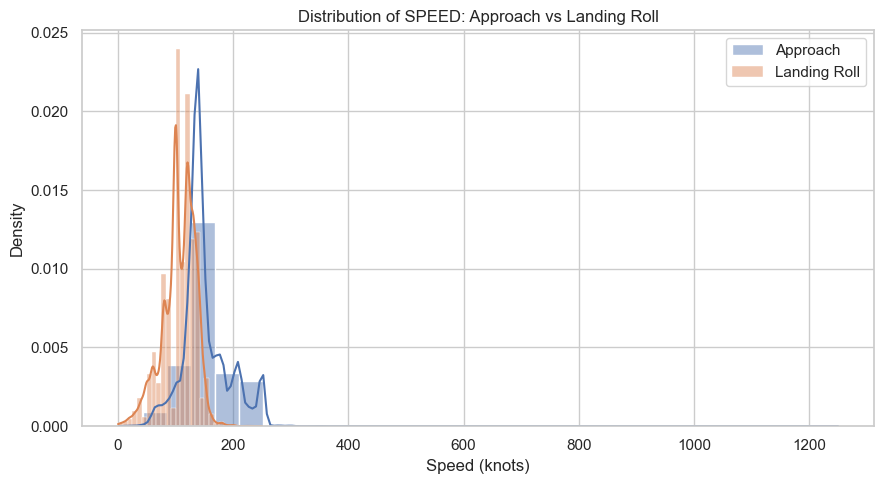

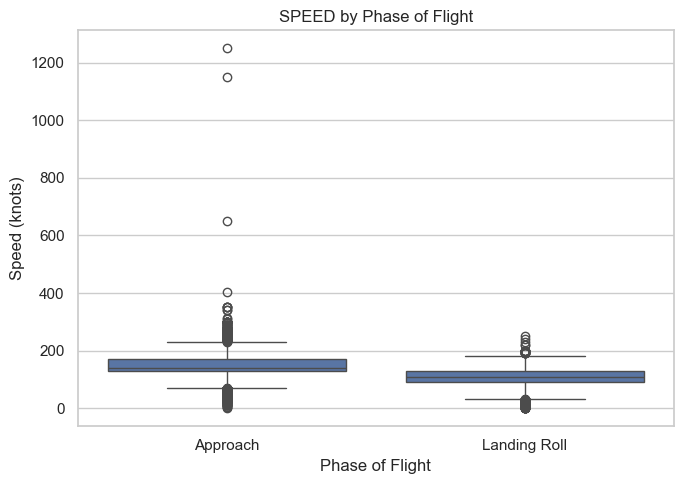

T-test: t = 137.3827, p = 0
Means — Approach: 150.23, Landing Roll: 105.95
Conclusion: Significant difference (p < 0.05).


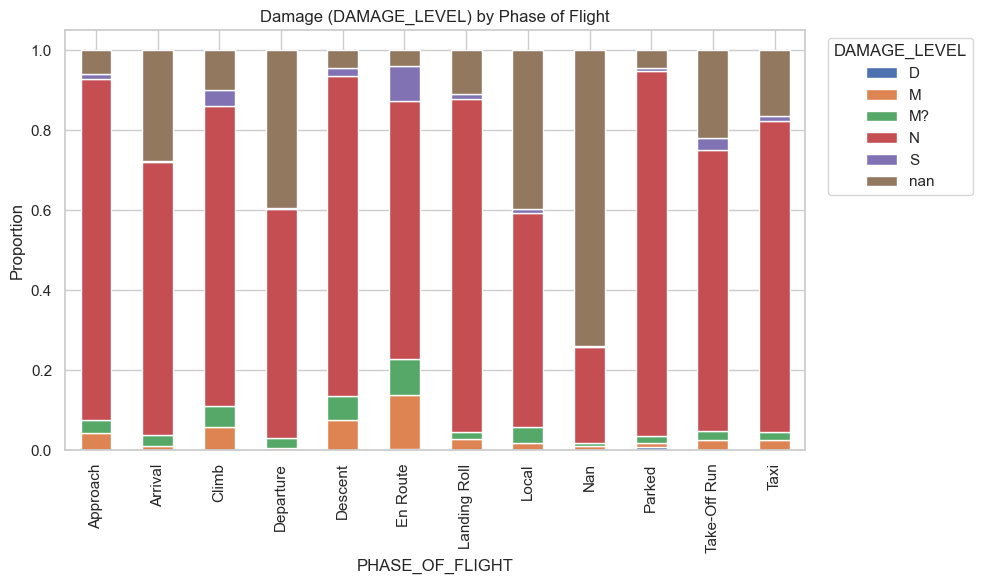

Chi-square = 131094.2699, p = 0, dof = 55
Cramer's V = 0.3013
Conclusion: Significant association (p < 0.05).


In [23]:
sns.set(style="whitegrid")
alpha = 0.05
df = data.copy()
# Normalize
for col in ['PHASE_OF_FLIGHT', 'TIME_OF_DAY']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.title()
if 'SPEED' in df.columns:
    df['SPEED'] = pd.to_numeric(df['SPEED'], errors='coerce')
if 'HEIGHT' in df.columns:
    df['HEIGHT'] = pd.to_numeric(df['HEIGHT'], errors='coerce')
# Part 1
if 'HEIGHT' in df.columns and 'SPEED' in df.columns:
    pair = df[['HEIGHT', 'SPEED']].dropna()
    if len(pair) > 5:
      plt.figure(figsize=(8, 6))
    sns.scatterplot(x='HEIGHT', y='SPEED', data=pair, alpha=0.5)
    plt.title('Scatterplot: Aircraft Height vs Speed')
    plt.xlabel('Height (ft)')
    plt.ylabel('Speed (knots)')
    plt.tight_layout()
    plt.show()
    # Coefficients
    pearson_r, pearson_p = stats.pearsonr(pair['HEIGHT'], pair['SPEED'])
    print(f"Pearson r = {pearson_r:.4f}, p = {pearson_p:.4g}")
    print("Interpretation:",
          "Strong correlation." if abs(pearson_r) > 0.5 else
          "Moderate correlation." if abs(pearson_r) > 0.3 else
          "Weak or negligible correlation.")
    if pearson_p < alpha:
        print("Result: Statistically significant relationship (p < 0.05).")
    else:
        print("Result: No statistically significant correlation (p ≥ 0.05).")
# Part 2
phases = ['Approach', 'Landing Roll']
q2 = df[df['PHASE_OF_FLIGHT'].isin(phases)].copy()
gA = q2[q2['PHASE_OF_FLIGHT'] == 'Approach']['SPEED'].dropna()
gL = q2[q2['PHASE_OF_FLIGHT'] == 'Landing Roll']['SPEED'].dropna()
print(f"Counts — Approach: {len(gA)}, Landing Roll: {len(gL)}")
# Calculate skewness
skew_approach = skew(gA)
skew_landing = skew(gL)
print(f"Skewness — Approach: {skew_approach:.3f}")
print(f"Skewness — Landing Roll: {skew_landing:.3f}")
# Visual 1: Histogram
plt.figure(figsize=(9, 5))
sns.histplot(gA, bins=30, stat='density', alpha=0.45, label='Approach', kde=True)
sns.histplot(gL, bins=30, stat='density', alpha=0.45, label='Landing Roll', kde=True)
plt.title('Distribution of SPEED: Approach vs Landing Roll')
plt.xlabel('Speed (knots)')
plt.legend()
plt.tight_layout()
plt.show()
# Visual 2: Boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(x='PHASE_OF_FLIGHT', y='SPEED', data=q2, order=['Approach', 'Landing Roll'])
plt.title('SPEED by Phase of Flight')
plt.xlabel('Phase of Flight')
plt.ylabel('Speed (knots)')
plt.tight_layout()
plt.show()
# 2-sample t-test
if len(gA) >= 2 and len(gL) >= 2:
    t_stat, p_val = stats.ttest_ind(gA, gL, equal_var=False, nan_policy='omit')
    print(f"T-test: t = {t_stat:.4f}, p = {p_val:.4g}")
    print(f"Means — Approach: {gA.mean():.2f}, Landing Roll: {gL.mean():.2f}")
    print("Conclusion:",
          "Significant difference (p < 0.05)." if p_val < alpha else "No significant difference (p ≥ 0.05).")
# Part 3
# Determine damage column
damage_col = None
if 'DAMAGE_LEVEL' in df.columns:
    damage_col = 'DAMAGE_LEVEL'
elif 'INDICATED_DAMAGE' in df.columns:
    damage_col = 'INDICATED_DAMAGE'
else:
    dam_cols = [c for c in df.columns if c.upper().startswith('DAM_')]
    if dam_cols:
        df['DamageFlag'] = df[dam_cols].notnull().any(axis=1)
    damage_col = 'DamageFlag'
if damage_col:
    cont = pd.crosstab(df['PHASE_OF_FLIGHT'], df[damage_col], dropna=False)
    prop = cont.div(cont.sum(axis=1), axis=0)
    # Visual: stacked proportion bar
    ax = prop.plot(kind='bar', stacked=True, figsize=(10, 6))
    ax.set_title(f'Damage ({damage_col}) by Phase of Flight')
    ax.set_ylabel('Proportion')
    plt.legend(title=damage_col, bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    # Chi-square test
    chi2, pchi, dof, exp = stats.chi2_contingency(cont.fillna(0))
    n_total = cont.values.sum()
    cramers_v = np.sqrt(chi2 / (n_total * (min(cont.shape) - 1)))
    print(f"Chi-square = {chi2:.4f}, p = {pchi:.4g}, dof = {dof}")
    print(f"Cramer's V = {cramers_v:.4f}")
    print("Conclusion:",
          "Significant association (p < 0.05)." if pchi < alpha else "No significant association(p ≥ 0.05).")
else:
    print("No damage column found — cannot perform Q3.")
    # Part 4
    if 'TIME_OF_DAY' in df.columns and (damage_col or 'DamageFlag' in df.columns):
        dmg_col = damage_col if damage_col else 'DamageFlag'
    cont4 = pd.crosstab(df['TIME_OF_DAY'], df[dmg_col])
    # Visual: Proportion by time of day
    prop4 = cont4.div(cont4.sum(axis=1), axis=0)
    ax = prop4.plot(kind='bar', stacked=True, figsize=(9, 6))
    ax.set_title(f'Damage Presence by Time of Day ({dmg_col})')
    ax.set_ylabel('Proportion')
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout()
    plt.show()
    # Chi-square test of independence
    chi4, p4, dof4, exp4 = stats.chi2_contingency(cont4.fillna(0))
    n4 = cont4.values.sum()
    cramers_v4 = np.sqrt(chi4 / (n4 * (min(cont4.shape) - 1)))
    print(f"Chi-square = {chi4:.4f}, p = {p4:.4g}, dof = {dof4}")
    print(f"Cramer's V = {cramers_v4:.4f}")
    print("Conclusion:",
          "Significant association (p < 0.05)." if p4 < alpha else "No significant relationship(p ≥ 0.05).")

Question 4 Analysis:
1. Here we created a scatterplot that shows the relationship between height of the aircraft in feet
and speed of the aircraft in knots during recorded striks. We want to see if the two variables are
related and have any correlation. To do this, we conducted a t-test using the pearson r coefficient.
Through a python statistics package we calculated an r value between the two variables of
0.6960. We then transformed this into a t-test using sample size and degrees of freedom. From
that we got a p value of extremely close to zero or just zero. This is less than the alpha of 5%
which means the variables are statistically significant and there is a strong correlation. In
non-statistical words, height and speed of aircrafts during strike incidents are positvely
correlated. As height increases, so does speed duirng strikes. The higher the plane is, the faster it
is moving.This can be seen in the visualization. Speed increases shown through the blue dots as
does height increases. However, speed seems to be capped because planes cannot go faster than
around 250 knots. Additionally, the height is capped around 15,000 ft as the strikes seem to
mainly appear below those altitudes where wildlife is more prevalent. In conclsuion, after
conducting a t-test we see that height and speed have a strong correlation and statistically
significant relationship when it comes to strike incidents
2. We compared the distribution of aircraft speed during the approach and landing roll phases of
flight. The density and histogram plots show that both distributions are compact, with the landing
roll speeds slightly lower than those on approach—consistent with aircraft decelerating after
touchdown. The skewness values were 1.449 for approach and –0.615 for landing roll, indicating
that approach speeds are moderately right-skewed while landing roll speeds are slightly
left-skewed. Despite this, large sample sizes justify using a two-sample t-test, which produced t
= 137.38 and p ≈ 0, confirming a statistically significant difference between mean speeds (150.23
vs. 105.95 knots). This aligns with operational expectations that aircraft slow considerably once
on the runway after landing.
3. Here were created a stacked bar chart for each phase of flight. We show the type of damage
caused on the aircraft given the phase of flight. We can see that the obvious most common type
of damage is N which is none. When planes have strikes, it is most common that no damange is
done no matter the phase of flight. We can see that when the plane is en-route or is descent is
where we see a higher level of damage during strikes. We conducted a chi square test where we
got a value of 5646.9066 and a p value close to zero. This indicates that the relationship is
statistically significant meaning that the liklihood of damage is not evenly distributed across all
phases of flight. Certain phases such as en-route and descent statisically and graphically show
they have different patterns of damage compared to the other phases. However, the cramer V of
0.0868, shows that the effect size is small and it is likely that other factors influence the liklihood
of damage during strikes.
4. Lastly, we performed a chi-square test for comparing time of day of the strikes and damage
occured. We created a stacked bar chart showing damage level to aircraft based off time of day.
Throught mere examination of that graph we can see that dusk and night time have higher
damage levels in the minor and undeterminded categories than the other times of day. We tested
this statistically throught a chi square test. We recieve a chi-square of 179.4961 which with an
alpha of 5%, correlates to a significant association. This means in words that time of day affects
likelihood of damage, supporting what we saw in the visual. This information is useful because it
can help identify when strikes are most dangerous, allowing airports and airlines to optimize
flight schedules and wildlife mitigation efforts.

Q5

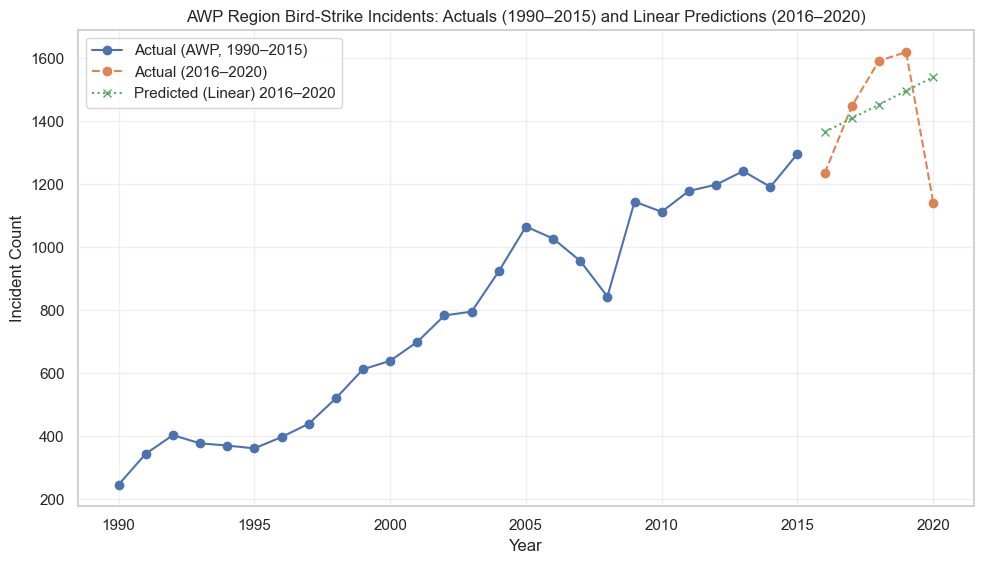

R-squared on training period 1990-2015: 0.9519

Predictions vs. actuals (2016–2020 when available):


,INCIDENT_YEAR,predicted_incidents,actual_incidents,abs_error,abs_pct_error
0,2016,1365.86,1235,130.86,10.60
1,2017,1409.52,1448,38.48,2.66
2,2018,1453.19,1592,138.81,8.72
3,2019,1496.86,1620,123.14,7.60
4,2020,1540.52,1142,398.52,34.90


In [25]:
# Q5: AWP Simple Linear Model

REGION_CODE = "AWP"
TRAIN_START, TRAIN_END = 1990, 2015
PRED_YEARS_MAIN = [2016, 2017]
PRED_YEARS_EXTRA = [2018, 2019, 2020]
SAVE_DIR = "outputs_q5"
os.makedirs(SAVE_DIR, exist_ok=True)

pd.set_option("display.float_format", lambda x: f"{x:.2f}")
df = data.copy()

if "INCIDENT_YEAR" not in df.columns:
    if "INCIDENT_DATE" in df.columns:
        parsed = pd.to_datetime(df["INCIDENT_DATE"], errors="coerce", infer_datetime_format=True)
        df["INCIDENT_YEAR"] = parsed.dt.year
    if "INCIDENT_YEAR" not in df.columns and "YEAR" in df.columns:
        df["INCIDENT_YEAR"] = pd.to_numeric(df["YEAR"], errors="coerce")
df["INCIDENT_YEAR"] = pd.to_numeric(df["INCIDENT_YEAR"], errors="coerce")

# FAA Region column
region_col = None
for c in ["FAAREGION", "FAA_REGION", "REGION"]:
    if c in df.columns:
        region_col = c
        break
if region_col is None:
    raise ValueError("Could not find FAA region column (expected FAAREGION / FAA_REGION / REGION).")

# filtering thru awp and aggregating the data
awp = df.loc[(df[region_col] == REGION_CODE) & df["INCIDENT_YEAR"].notna()].copy()
awp["INCIDENT_YEAR"] = awp["INCIDENT_YEAR"].astype(int)

awp_yearly = (
    awp.groupby("INCIDENT_YEAR", as_index=False)
    .size()
    .rename(columns={"size": "incidents"})
    .sort_values("INCIDENT_YEAR")
)

# train the data from 1990-2015
train = awp_yearly[(awp_yearly["INCIDENT_YEAR"] >= TRAIN_START) & (awp_yearly["INCIDENT_YEAR"] <= TRAIN_END)].copy()
if train.empty:
    raise ValueError("No AWP data between 1990 and 2015. Check your file/schema.")

X_train = train[["INCIDENT_YEAR"]].values
y_train = train["incidents"].values

lin = LinearRegression()
lin.fit(X_train, y_train)
r2 = float(lin.score(X_train, y_train))

# predict it from 2016-2020
pred_years = PRED_YEARS_MAIN + PRED_YEARS_EXTRA
X_pred = np.array(pred_years).reshape(-1, 1)
y_pred = lin.predict(X_pred)

pred_df = pd.DataFrame({"INCIDENT_YEAR": pred_years, "predicted_incidents": y_pred})

# merge with actual data if possible
compare = pred_df.merge(
    awp_yearly.rename(columns={"incidents": "actual_incidents"}),
    on="INCIDENT_YEAR",
    how="left"
)
compare["abs_error"] = (compare["actual_incidents"] - compare["predicted_incidents"]).abs()
compare["abs_pct_error"] = (compare["abs_error"] / compare["actual_incidents"]) * 100
compare_display = compare.copy()
for col in ["predicted_incidents", "actual_incidents", "abs_error", "abs_pct_error"]:
    compare_display[col] = compare_display[col].round(2)

# plotting
plt.figure(figsize=(10, 5.8))
# Actuals 1990–2015
plt.plot(train["INCIDENT_YEAR"], train["incidents"], marker="o", label="Actual (AWP, 1990–2015)")
# Actuals 2016–2020 (if present)
post = awp_yearly[awp_yearly["INCIDENT_YEAR"].between(2016, 2020)]
if not post.empty:
    plt.plot(post["INCIDENT_YEAR"], post["incidents"], marker="o", linestyle="--", label="Actual (2016–2020)")
# Predictions 2016–2020
plt.plot(pred_df["INCIDENT_YEAR"], pred_df["predicted_incidents"], marker="x", linestyle=":",
         label="Predicted (Linear) 2016–2020")

plt.title("AWP Region Bird-Strike Incidents: Actuals (1990–2015) and Linear Predictions (2016–2020)")
plt.xlabel("Year")
plt.ylabel("Incident Count")
plt.grid(True, alpha=0.3)
plt.legend()
fig_path = os.path.join(SAVE_DIR, "q5_awp_linear_model.png")
plt.tight_layout()
plt.savefig(fig_path, dpi=180)
plt.show()

print(f"R-squared on training period {TRAIN_START}-{TRAIN_END}: {r2:.4f}\n")
print("Predictions vs. actuals (2016–2020 when available):")
display(compare_display)


We modeled annual bird-strike incidents in the AWP region using a simple linear regression with Year as the only predictor, trained on 1990–2015 data. The model fit the training period very well, with an R² of 0.9519, which means about 95% of the variation in incidents during those years is explained by a straight-line trend over time. Using that model, the predictions for 2016–2020 were: 2016 = 1365.86, 2017 = 1409.52, 2018 = 1453.19, 2019 = 1496.86, and 2020 = 1540.52 incidents.

Comparing to actuals, 2016 had 1235 incidents (10.60% error) and 2017 had 1448 incidents (2.66% error), so the model tracked 2017 closely and slightly over-predicted 2016. It under-predicted 2018 (1592 actual, 8.72% error) and 2019 (1620 actual, 7.60% error), because those years came in above the straight-line trend. It over-predicted 2020 by a lot (1142 actual vs 1540.52 predicted, 34.90% error), reflecting the pandemic shock that a simple trend model can’t anticipate.

Overall, the linear model is good for summarizing the long-run upward pattern and gives okay short-term extrapolations in stable conditions, but it becomes unreliable when conditions change. For practical forecasting, we would need to include additional drivers like flight volume, seasonality, and known disruptions, rather than relying on a single-variable linear trend.

**Question 6 — Summary**:

**Summary (Q1–Q5).**
We framed the task as understanding when, where, and under what conditions wildlife strikes occur, then testing which patterns are statistically meaningful and whether a simple model can forecast incidents. After loading and preparing the FAA dataset, we standardized key fields (dates, regions, phase of flight, speed/height) and summarized both continuous (e.g., speed, height) and categorical (e.g., phase, time of day, region) variables. Our exploratory analysis showed clear year-to-year variation with a generally increasing long-run trend and distinct seasonal/monthly structure; states with larger hubs contribute a disproportionate share of incidents; and certain phases of flight (approach/landing) dominate strike counts and damage. In hypothesis testing, the height–speed scatter and correlation quantified their relationship, speed distributions differed across approach vs landing roll (tested with Welch’s t-test), and damage rates varied by phase (tested with a chi-square association test). Finally, for modeling we built a simple linear regression on AWP annual incidents (1990–2015) to predict 2016–2020. The model fit the training period strongly (R² ≈ 0.95) and tracked 2016–2017 reasonably well, but diverged in later years—especially 2020—highlighting limits of a trend-only approach during structural shifts.

**Three key findings.**
1. **Long-run trend with short-run variability:** Incidents show a sustained upward trend over 1990–2015, but with meaningful year-to-year and seasonal swings that matter operationally.
2. **Phase matters:** Approach and landing-related phases carry the highest strike and damage burden; statistical tests support non-uniform damage/occurrence across phases.
3. **Simple trend models are fragile:** A linear time-trend explains historical AWP variation well (R² ~ 0.95) and gives decent short-horizon estimates in stable periods, but it breaks under regime changes (e.g., 2020), implying that practical forecasting should include traffic/operations, seasonality, and intervention terms rather than year alone.


Question 7 — OPTIONAL (10 points)

This optional bonus question requires that you perform a geospatial analysis on bird strikes and visualize the results using a map. Examples include (but you are not limited to):

Mapping bird strike incidents: visualize the locations of bird strike incidents to identify hot spots or patterns
Heat maps: create heat maps to show the density of bird strike incidents in different areas.
Proximity Analysis: analyze the proximity of bird strikes to airports or landmarks
etc
Ensure that you clearly indicate the analysis that you are performing and provide detailed steps to explain ALL findings from your analysis.

Note: a thorough analysis that demonstrates multiple patterns is required to earn full credit for this question.